In [1]:
# ================================
# Libraries for LOS Regression Task
# ================================

# Core libraries
import pandas as pd
import numpy as np
import math

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: model selection & regression metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Statistical tests (EDA / feature selection)
from scipy.stats import mannwhitneyu

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


# Data prepration

Data Loading

In [ ]:
df_clean = pd.read_csv(r"HealthAI\data\cleaned_data.csv")
print(df_clean.shape)
df_clean.head()

(14622, 48)


,age,gender,residence_type,admission_type,length_of_stay_days,icu_stay_days,smoking_status,alcohol_use,diabetes_mellitus,hypertension,...,congenital_heart_disease,urinary_tract_infection,neurocardiogenic_syncope,orthostatic_hypotension,infective_endocarditis,deep_vein_thrombosis,cardiogenic_shock,shock,pulmonary_embolism,chest_infection
0,81,M,R,E,3,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,65,M,R,E,5,2,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,53,M,U,E,3,3,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,67,F,U,E,8,6,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,60,F,U,E,23,9,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Remove data leakage column (ICU stay is not known at admission time) - Data Leakage Prevention

df_clean = df_clean.drop(columns=['icu_stay_days'])

In [4]:
# 70% train, 30% temp
train_data, temp_data = train_test_split(
    df_clean, test_size=0.30, random_state=42
)

# Split temp into validation (15%) and test (15%)
validation_data, test_data = train_test_split(
    temp_data, test_size=0.50, random_state=42
)

print("Train data shape:", train_data.shape)
print("Validation data shape:", validation_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (10235, 47)
Validation data shape: (2193, 47)
Test data shape: (2194, 47)


# EDA

In [5]:
target = 'length_of_stay_days'

In [6]:
train_data.nunique()

age                                         95
gender                                       2
residence_type                               2
admission_type                               2
length_of_stay_days                         47
smoking_status                               2
alcohol_use                                  2
diabetes_mellitus                            2
hypertension                                 2
coronary_artery_disease                      2
prior_cardiomyopathy                         2
chronic_kidney_disease                       2
hemoglobin                                 168
total_leukocyte_count                      399
platelet_count                             604
glucose_level                              494
urea_level                                 278
creatinine_level                           412
raised_cardiac_enzymes                       2
severe_anemia                                2
anemia                                       2
stable_angina

Feature Type Identification Using Cardinality (Binary vs Continuous)

In [7]:
categorical_cols = train_data.columns[train_data.nunique()<=2]
numerical_cols = train_data.columns[train_data.nunique()>2]

print("categorical_cols", categorical_cols.tolist())
print("numerical_cols", numerical_cols.tolist())

categorical_cols ['gender', 'residence_type', 'admission_type', 'smoking_status', 'alcohol_use', 'diabetes_mellitus', 'hypertension', 'coronary_artery_disease', 'prior_cardiomyopathy', 'chronic_kidney_disease', 'raised_cardiac_enzymes', 'severe_anemia', 'anemia', 'stable_angina', 'acute_coronary_syndrome', 'st_elevation_myocardial_infarction', 'atypical_chest_pain', 'heart_failure', 'hf_reduced_ejection_fraction', 'hf_normal_ejection_fraction', 'valvular_heart_disease', 'complete_heart_block', 'sick_sinus_syndrome', 'acute_kidney_injury', 'cva_infarct', 'cva_bleed', 'atrial_fibrillation', 'ventricular_tachycardia', 'paroxysmal_supraventricular_tachycardia', 'congenital_heart_disease', 'urinary_tract_infection', 'neurocardiogenic_syncope', 'orthostatic_hypotension', 'infective_endocarditis', 'deep_vein_thrombosis', 'cardiogenic_shock', 'shock', 'pulmonary_embolism', 'chest_infection']
numerical_cols ['age', 'length_of_stay_days', 'hemoglobin', 'total_leukocyte_count', 'platelet_count', 

## Univariate analysis

### Numarical Features


===== Numeric Feature: age =====
Skewness: -0.49
mean: 61.48 | median: 62.0


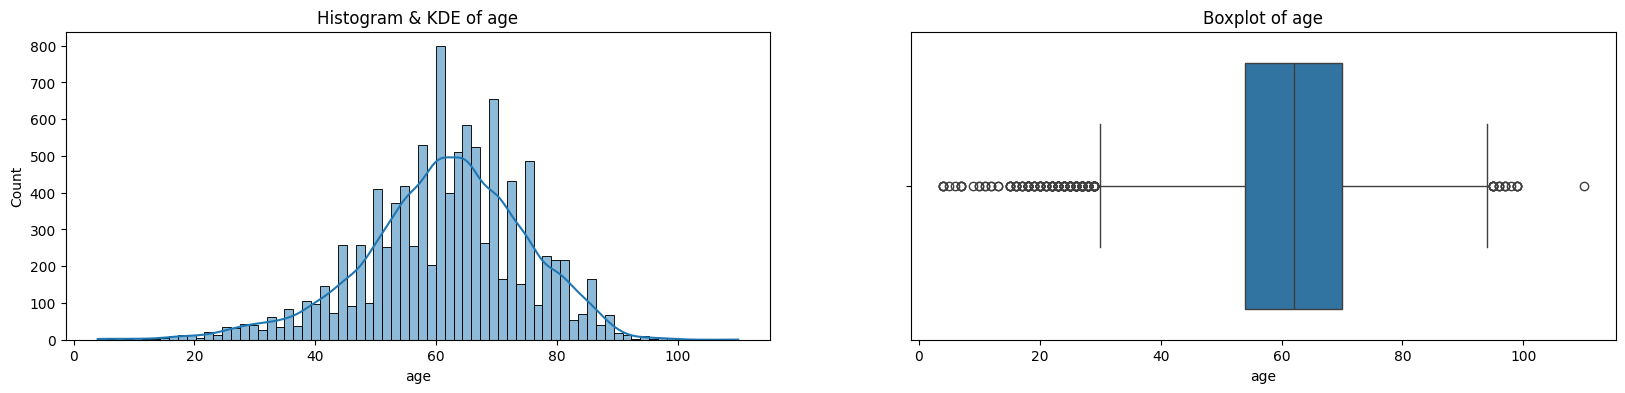


===== Numeric Feature: length_of_stay_days =====
Skewness: 3.11
mean: 6.53 | median: 5.0


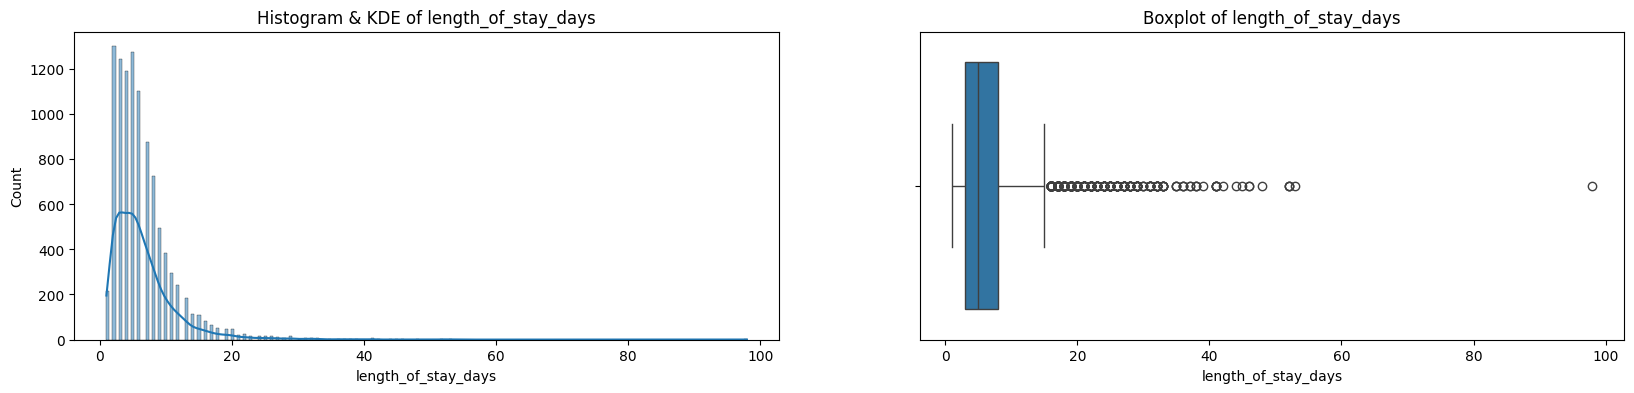


===== Numeric Feature: hemoglobin =====
Skewness: -0.26
mean: 12.25 | median: 12.4


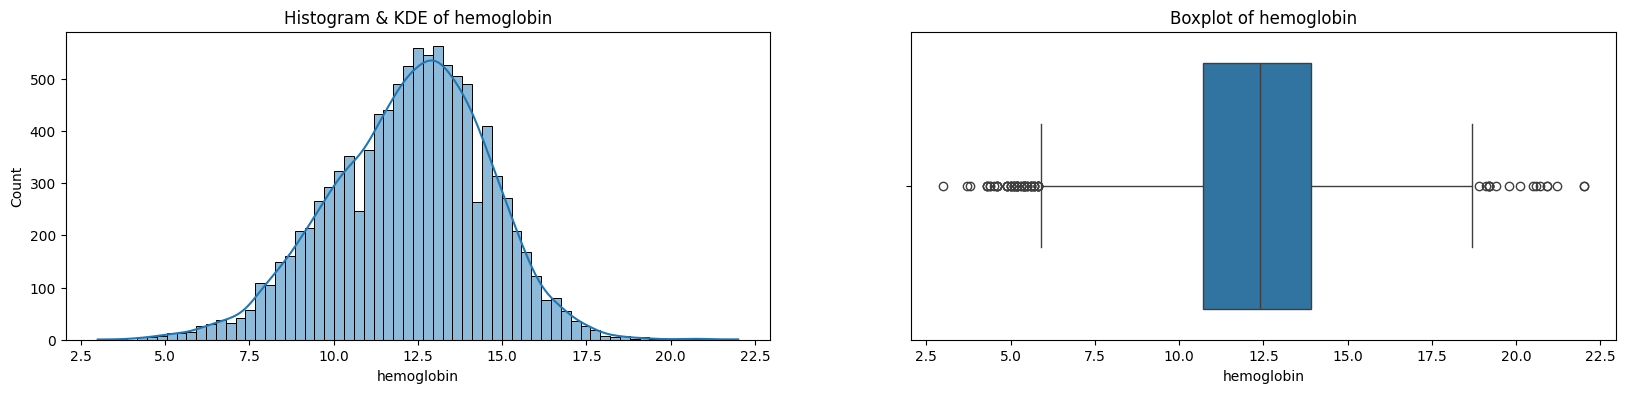


===== Numeric Feature: total_leukocyte_count =====
Skewness: 5.32
mean: 11.33 | median: 10.0


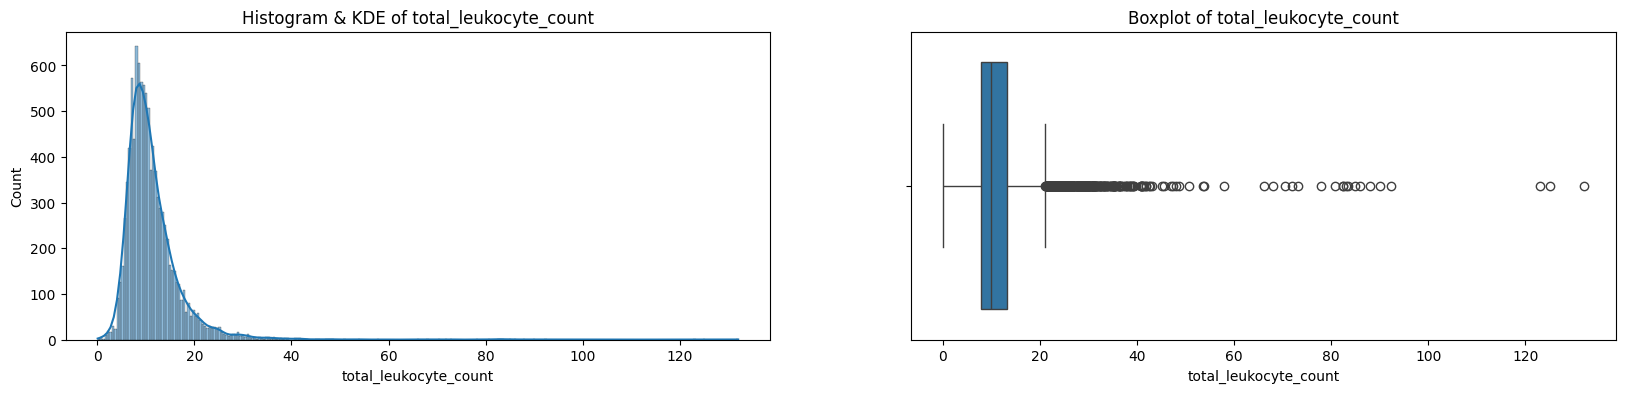


===== Numeric Feature: platelet_count =====
Skewness: 1.34
mean: 238.64 | median: 226.0


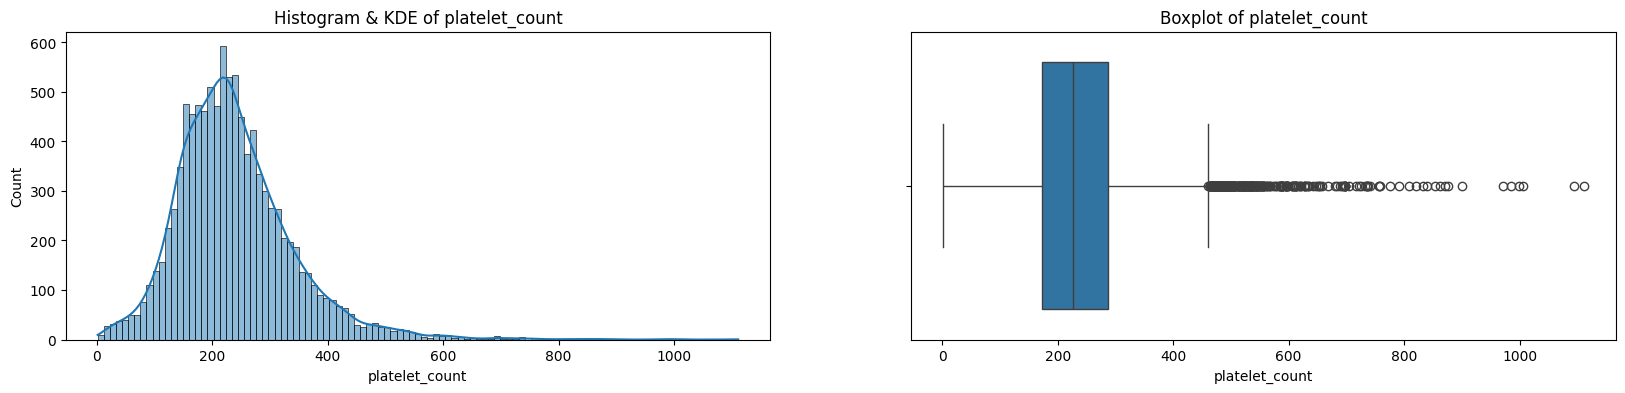


===== Numeric Feature: glucose_level =====
Skewness: 2.01
mean: 162.54 | median: 135.0


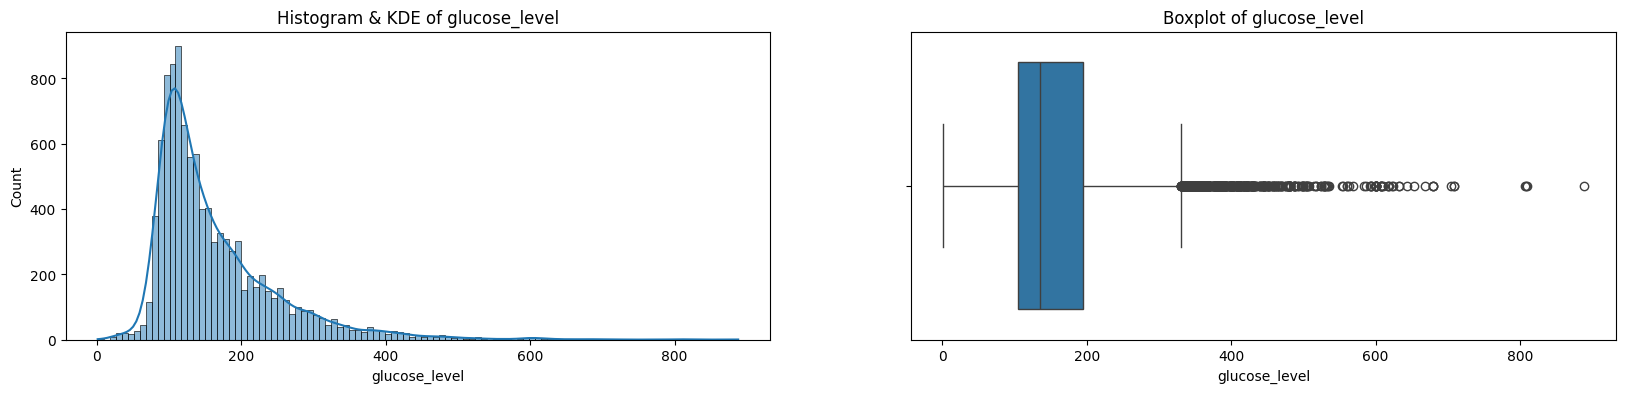


===== Numeric Feature: urea_level =====
Skewness: 2.87
mean: 49.46 | median: 35.0


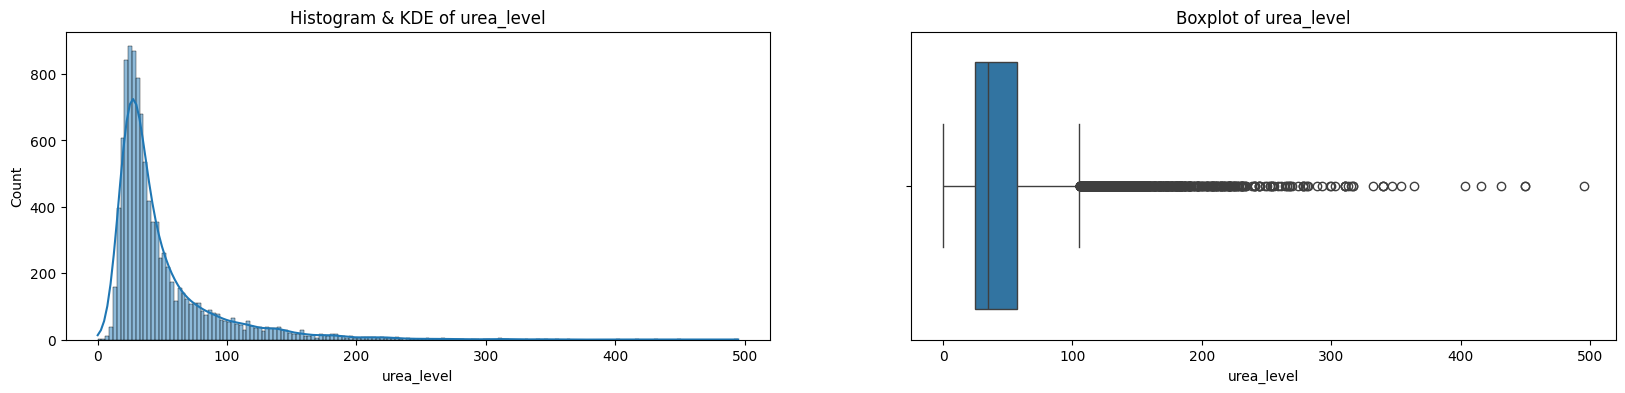


===== Numeric Feature: creatinine_level =====
Skewness: 3.8
mean: 1.33 | median: 0.99


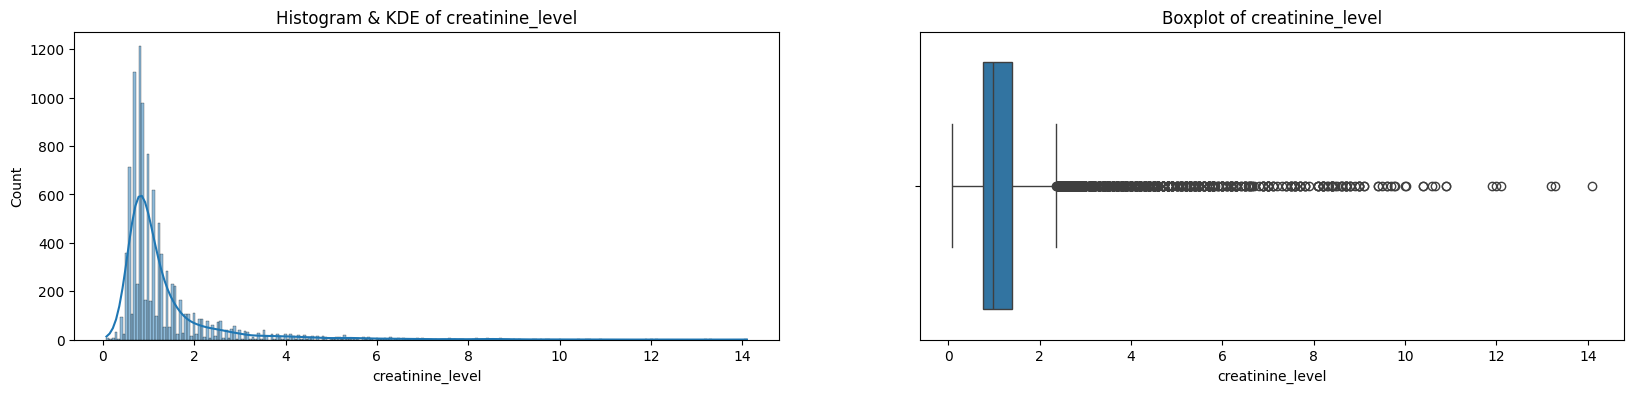

In [8]:
# Univariate analysis

for col in numerical_cols:
    print(f"\n===== Numeric Feature: {col} =====")
    print("Skewness:", round(train_data[col].skew(), 2))

    print("mean:", round(train_data[col].mean(), 2), "| median:", round(train_data[col].median(), 2))

    fig, axes = plt.subplots(1,2, figsize = (20,4))

    sns.histplot(x = train_data[col], kde=True, ax = axes[0] )
    axes[0].set_title(f"Histogram & KDE of {col}")

    sns.boxplot(x = train_data[col], ax = axes[1])
    axes[1].set_title(f"Boxplot of {col}")

    plt.show()

### categorical features

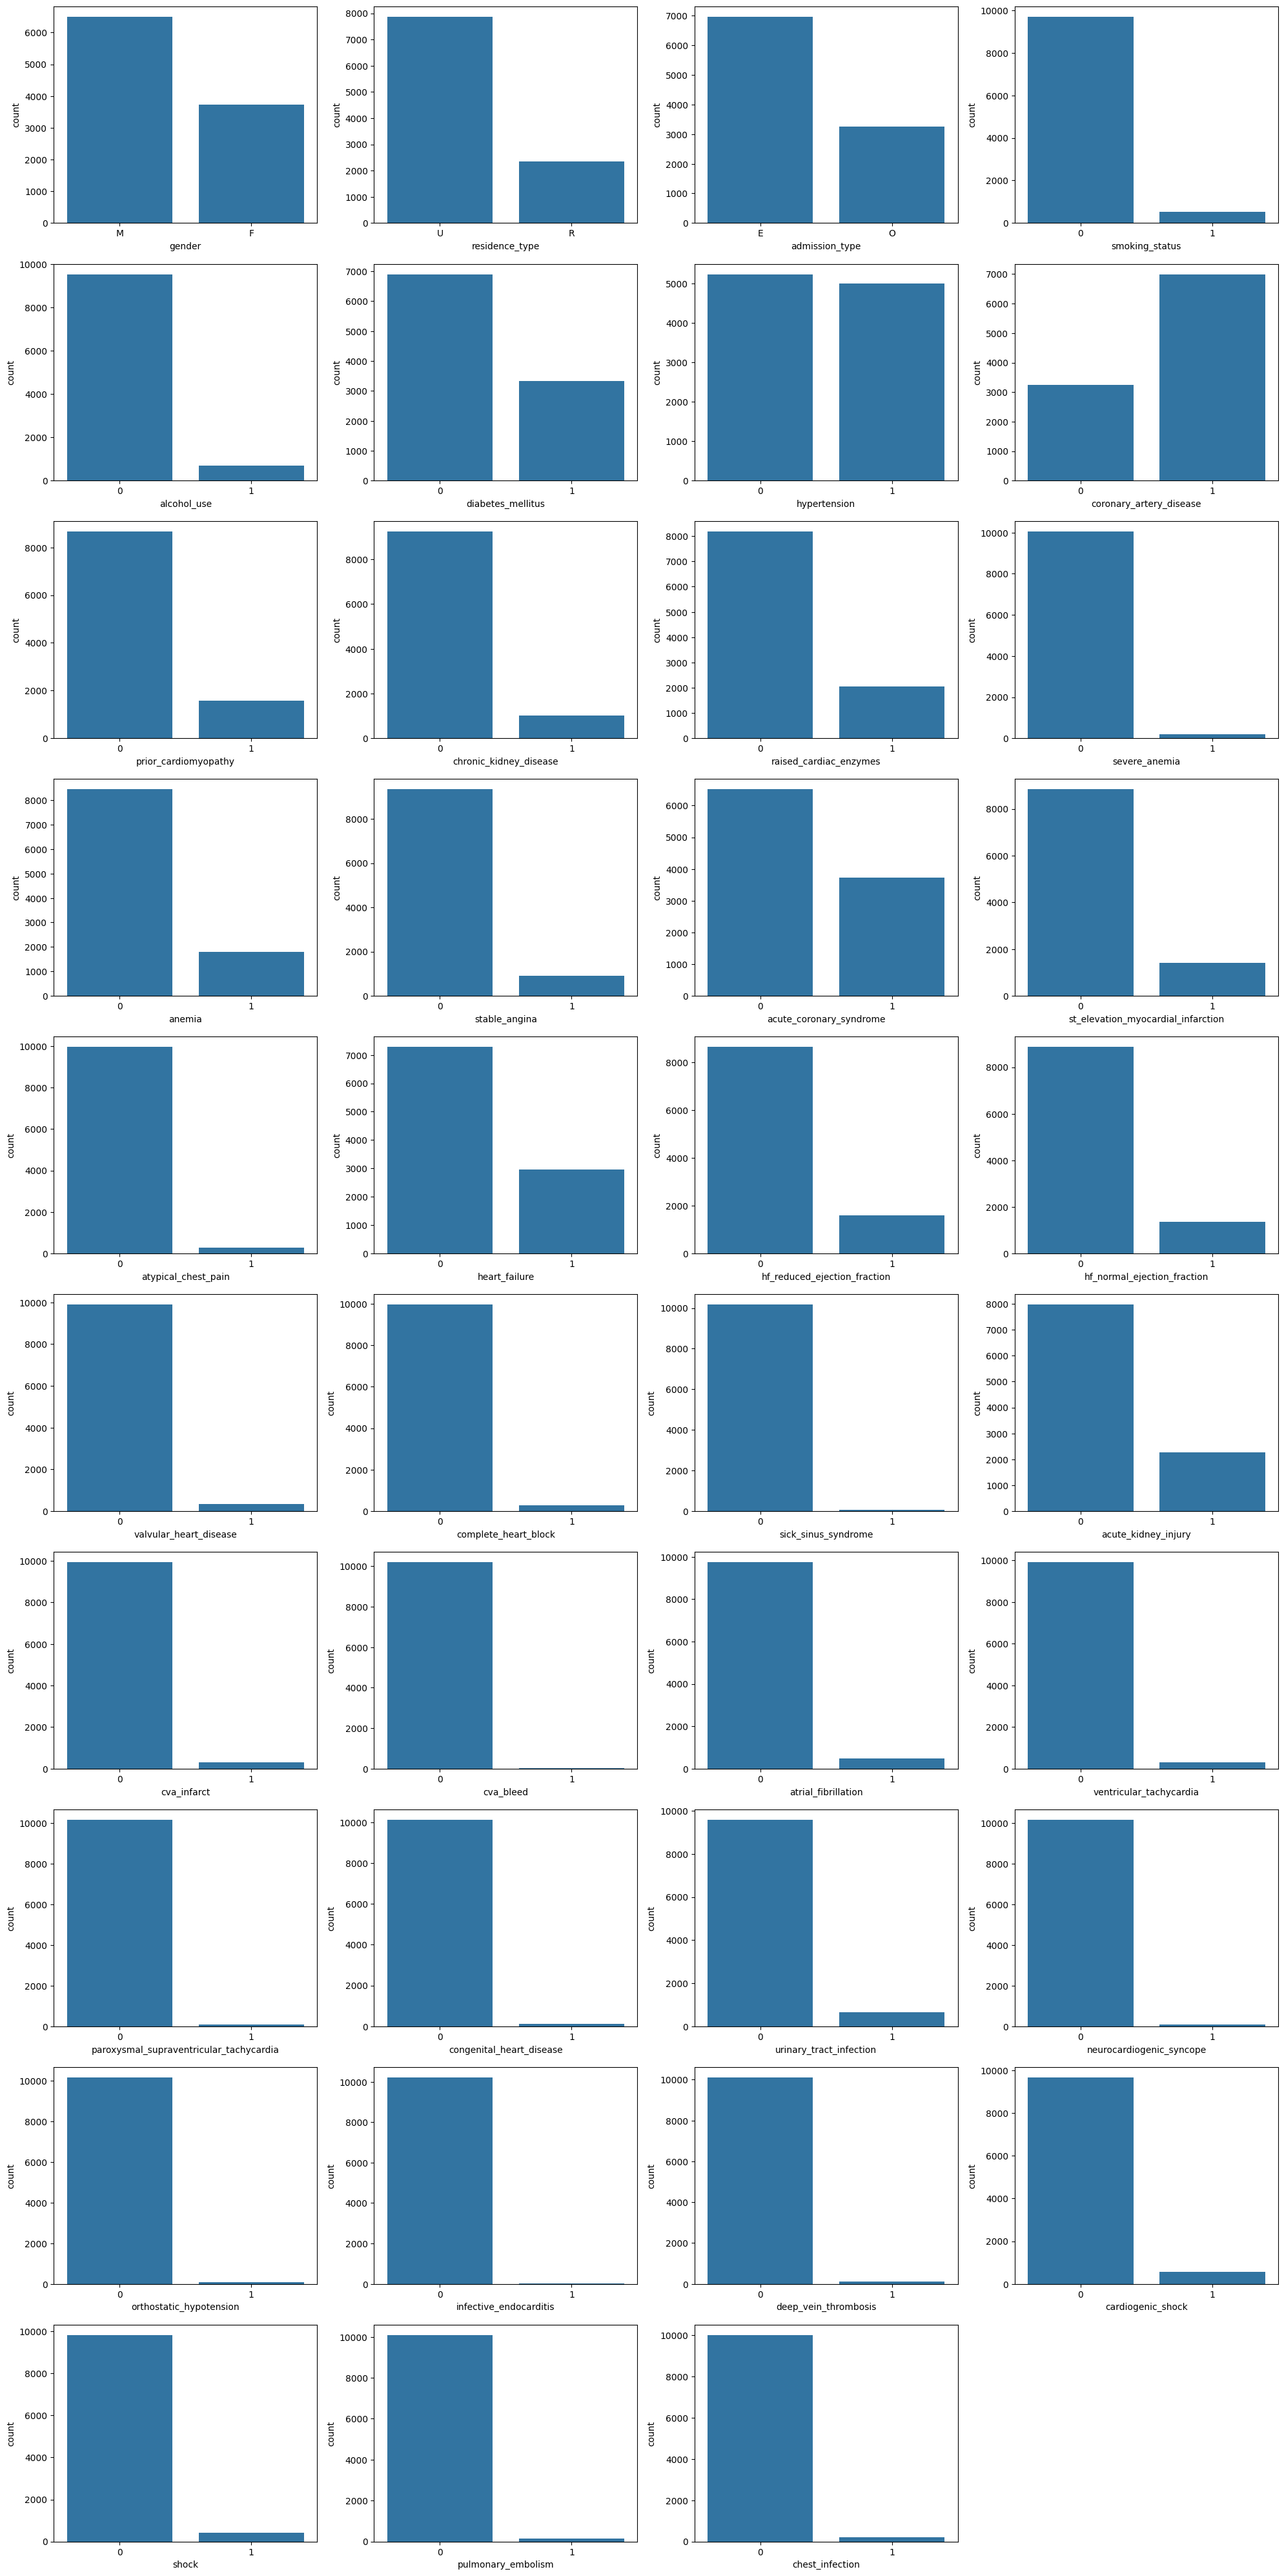

In [9]:
# univariate analysis for categorical_cols

n = len(categorical_cols)
cols = 4

rows = math.ceil(n / cols)
plt.figure(figsize=(20, rows * 4))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(x = train_data[col])

plt.tight_layout()
plt.show()

## Bivariate Aanalysis

### categorical feature vs Target

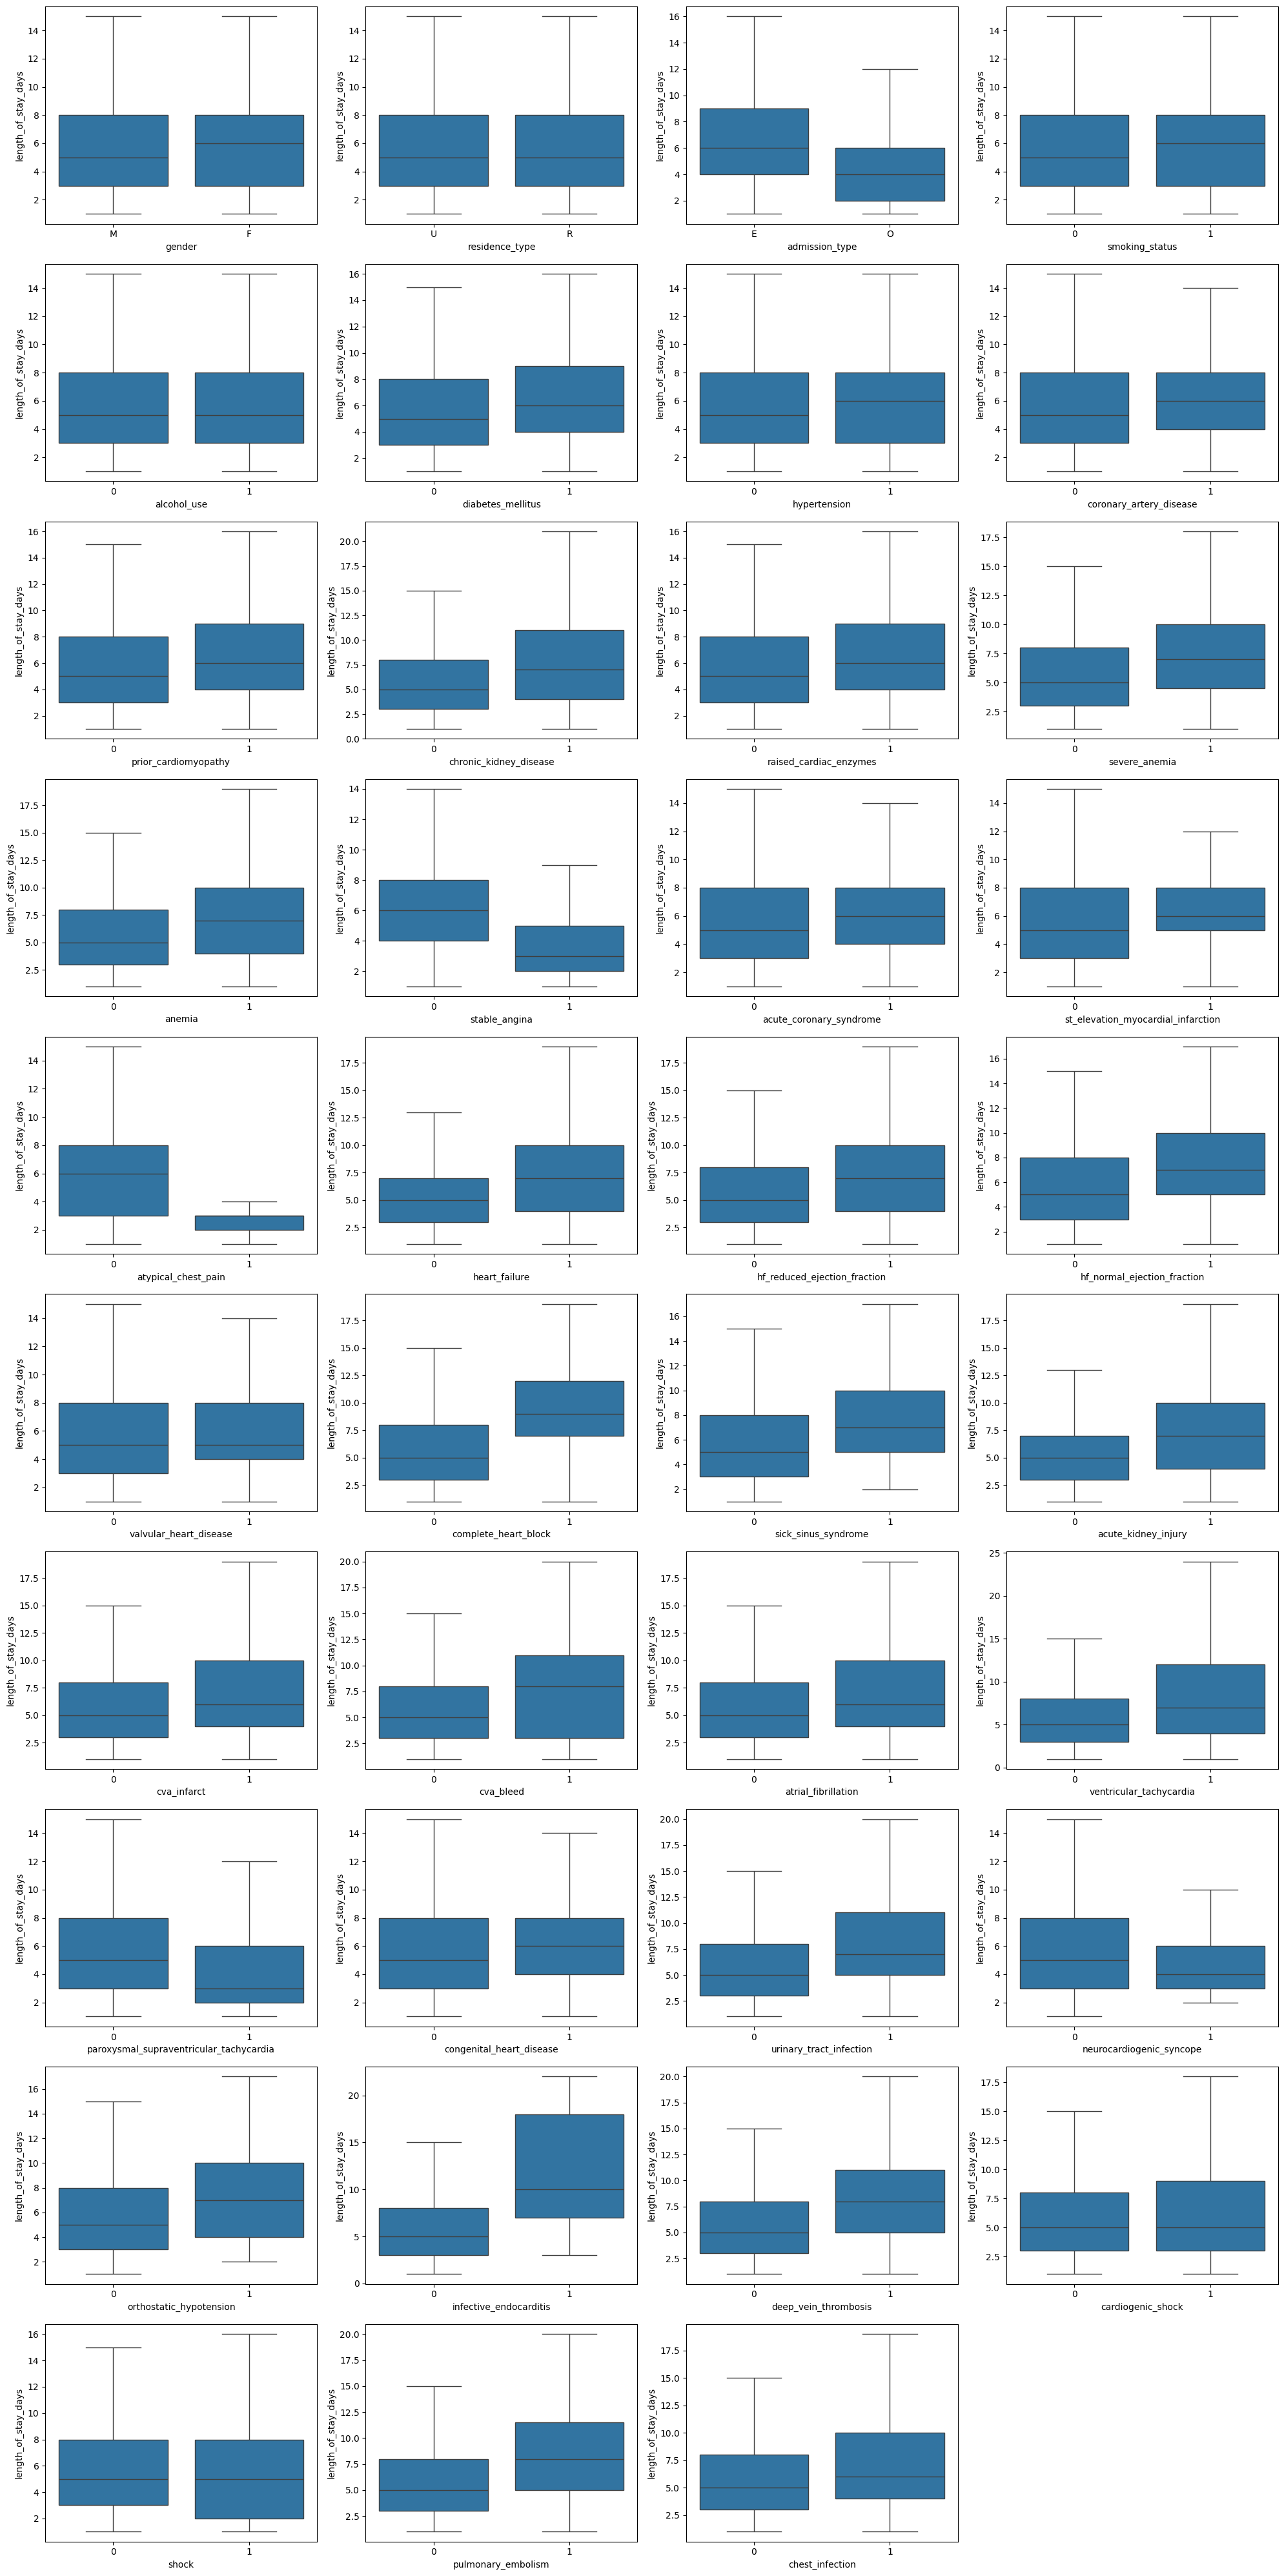

In [10]:
n = len(categorical_cols)
cols = 4

# Auto-calc rows
rows = math.ceil(n / cols)

# Auto figure size (height grows with rows)
plt.figure(figsize=(20, rows * 4))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x = train_data[col], y = train_data[target], showfliers = False)

plt.tight_layout()
plt.show()

### Numarical feature vs  target

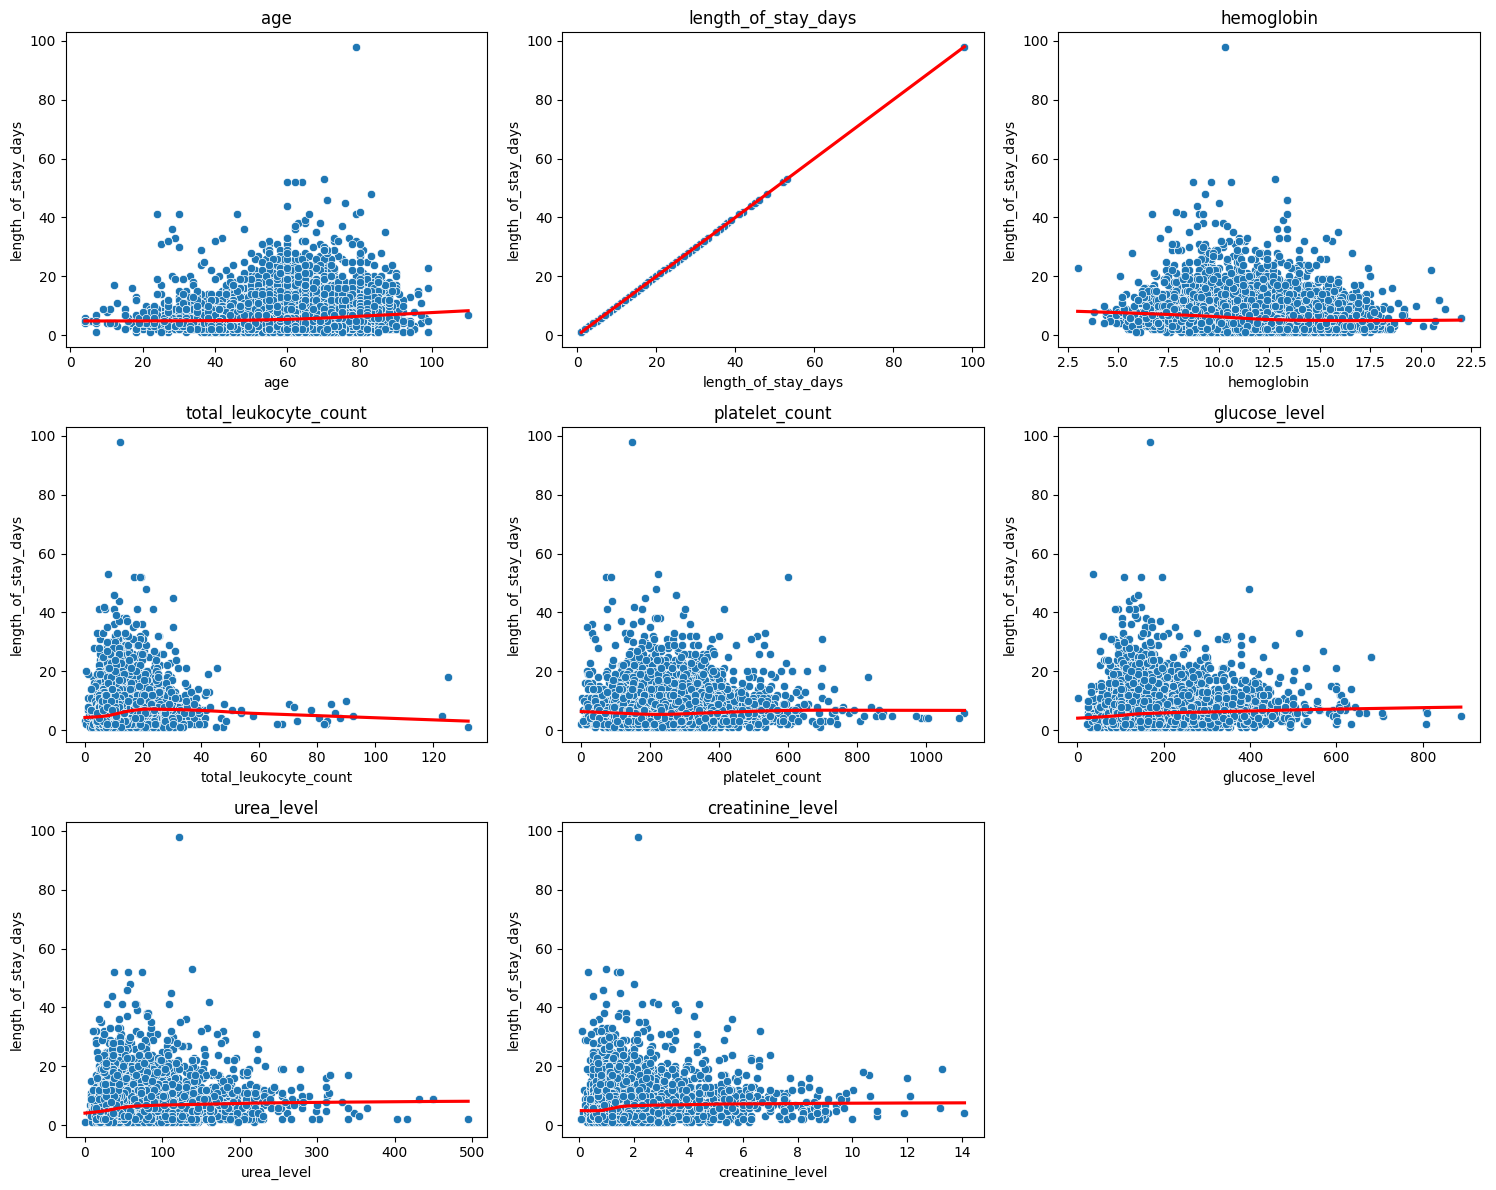

In [11]:
n_cols = 3  # columns per row (adjust if needed)
n_features = len(numerical_cols)
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    
    sns.scatterplot(
        x=train_data[col],
        y=train_data[target],
        ax=ax
    )
    
    sns.regplot(
        x=train_data[col],
        y=train_data[target],
        scatter=False,
        lowess=True,
        line_kws={"color": "red"},
        ax=ax
    )
    
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel(target)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

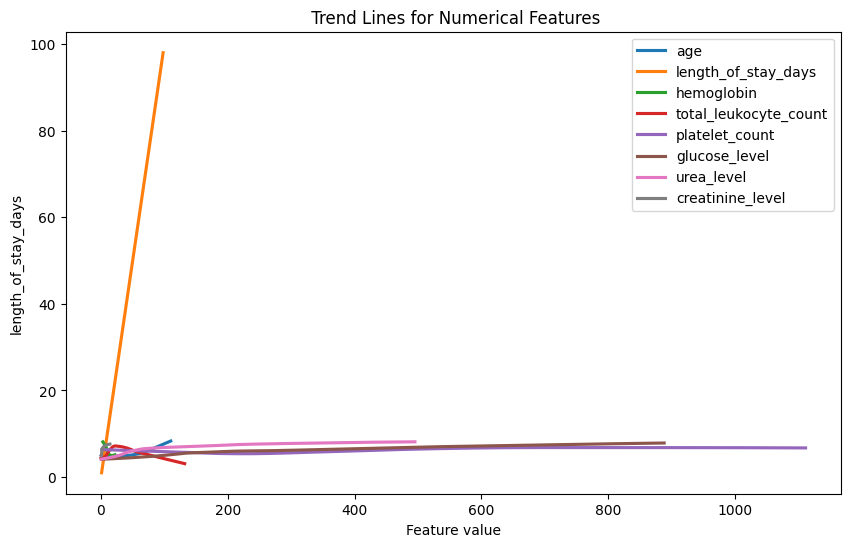

In [12]:
plt.figure(figsize=(10,6))

for col in numerical_cols:
    sns.regplot(
        x=train_data[col],
        y=train_data[target],
        scatter=False,
        lowess=True,
        label=col
    )

plt.xlabel("Feature value")
plt.ylabel(target)
plt.title(" Trend Lines for Numerical Features")
plt.legend()
plt.show()

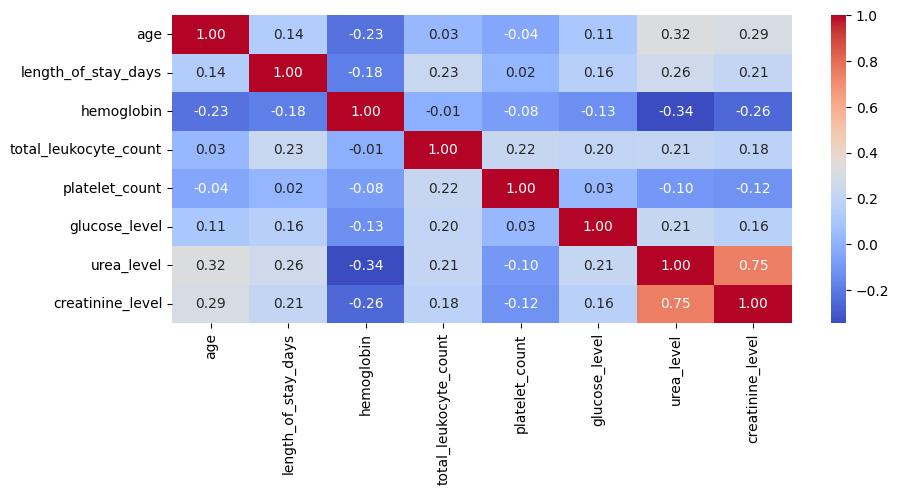

In [13]:
heatmap_df = train_data[list(numerical_cols)].corr(method="spearman")

plt.figure(figsize=(10,4))
sns.heatmap(heatmap_df, cmap="coolwarm", annot=True, fmt=".2f")
plt.show()

## Stastical tests

In [14]:
binary_numeric_cols = [
    col for col in categorical_cols
    if train_data[col].dropna().isin([0, 1]).all()
]

binary_string_cols = [
    col for col in categorical_cols
    if col not in binary_numeric_cols
]

print("Binary numeric cols:", binary_numeric_cols)
print("Binary string cols:", binary_string_cols)

Binary numeric cols: ['smoking_status', 'alcohol_use', 'diabetes_mellitus', 'hypertension', 'coronary_artery_disease', 'prior_cardiomyopathy', 'chronic_kidney_disease', 'raised_cardiac_enzymes', 'severe_anemia', 'anemia', 'stable_angina', 'acute_coronary_syndrome', 'st_elevation_myocardial_infarction', 'atypical_chest_pain', 'heart_failure', 'hf_reduced_ejection_fraction', 'hf_normal_ejection_fraction', 'valvular_heart_disease', 'complete_heart_block', 'sick_sinus_syndrome', 'acute_kidney_injury', 'cva_infarct', 'cva_bleed', 'atrial_fibrillation', 'ventricular_tachycardia', 'paroxysmal_supraventricular_tachycardia', 'congenital_heart_disease', 'urinary_tract_infection', 'neurocardiogenic_syncope', 'orthostatic_hypotension', 'infective_endocarditis', 'deep_vein_thrombosis', 'cardiogenic_shock', 'shock', 'pulmonary_embolism', 'chest_infection']
Binary string cols: ['gender', 'residence_type', 'admission_type']


In [15]:
# 1. Define binary string mappings
binary_string_map = {
    "gender": {"M": 0, "F": 1},
    "residence_type": {"U": 0, "R": 1},
    "admission_type": {"O": 0, "E": 1}
}

# Temporary dataframe for testing
temp_df = train_data.copy()

# Encode string binary columns
for col, mapping in binary_string_map.items():
    temp_df[col] = temp_df[col].map(mapping)

# Combine all categorical features to test
all_binary_categorical_cols = list(binary_numeric_cols) + list(binary_string_map.keys())

# -----------------------------
# 2. Mann–Whitney U test loop
# -----------------------------
cat_bivariate = []

for col in all_binary_categorical_cols:
    los_0 = temp_df.loc[temp_df[col] == 0, target]
    los_1 = temp_df.loc[temp_df[col] == 1, target]

    # Safety check for very rare features
    if len(los_1) < 20:
        p_value = None
    else:
        _, p_value = mannwhitneyu(los_0, los_1, alternative="two-sided")

    median_0 = los_0.median()
    median_1 = los_1.median()

    cat_bivariate.append({
        "feature": col,
        "median_LOS_0": median_0,
        "median_LOS_1": median_1,
        "diff_days": median_1 - median_0,
        "p_value": None if p_value is None else round(p_value, 5)
    })

# -----------------------------
# 3. Final result dataframe
# -----------------------------
cat_bivariate_df = (
    pd.DataFrame(cat_bivariate)
    .sort_values("diff_days", ascending=False)
    .reset_index(drop=True)
)

cat_bivariate_df


,feature,median_LOS_0,median_LOS_1,diff_days,p_value
0,infective_endocarditis,5.0,10.0,5.0,0.00030
1,complete_heart_block,5.0,9.0,4.0,0.00000
2,pulmonary_embolism,5.0,8.0,3.0,0.00000
3,deep_vein_thrombosis,5.0,8.0,3.0,0.00000
4,cva_bleed,5.0,8.0,3.0,0.01284
5,sick_sinus_syndrome,5.0,7.0,2.0,0.00047
6,heart_failure,5.0,7.0,2.0,0.00000
7,orthostatic_hypotension,5.0,7.0,2.0,0.00808
8,urinary_tract_infection,5.0,7.0,2.0,0.00000
9,ventricular_tachycardia,5.0,7.0,2.0,0.00000


In [16]:
num_target_corr = (
    train_data[numerical_cols]
    .corrwith(train_data[target], method="spearman")
    .sort_values()
)

num_target_corr

hemoglobin              -0.181781
platelet_count           0.020386
age                      0.138397
glucose_level            0.155775
creatinine_level         0.211188
total_leukocyte_count    0.225748
urea_level               0.258293
length_of_stay_days      1.000000
dtype: float64

### Catagrocal feature encoding

In [17]:
train_data['gender'] = train_data['gender'].map({'M': 1,'F': 0})
train_data['admission_type'] = train_data['admission_type'].map({'E': 1,'O': 0})
train_data['residence_type'] = train_data['residence_type'].map({'R': 1,'U': 0})


test_data['gender'] = test_data['gender'].map({'M':1,'F': 0})
test_data['admission_type'] = test_data['admission_type'].map({'E': 1,'O': 0})
test_data['residence_type'] = test_data['residence_type'].map({'R':1,'U': 0})

validation_data['gender'] = test_data['gender'].map({'M':1,'F': 0})
validation_data['admission_type'] = test_data['admission_type'].map({'E': 1,'O': 0})
validation_data['residence_type'] = test_data['residence_type'].map({'R':1,'U': 0})

### Outlier Handling

In [18]:
# IQR-based outlier capping (fit on train, apply to train & test)

train_capped = train_data.copy()
test_capped = test_data.copy()
validation_capped = validation_data.copy()
iqr_caps = {}

for col in numerical_cols:
    Q1 = train_capped[col].quantile(0.25)
    Q3 = train_capped[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    iqr_caps[col] = (lower, upper)

    # Apply capping
    train_capped[col] = train_capped[col].clip(lower, upper)
    test_capped[col] = test_capped[col].clip(lower, upper)
    validation_capped[col] = validation_capped[col].clip(lower, upper)

### Spliting the data for model training target and featurs

In [19]:
x_train = train_capped.drop([target], axis=1)
y_train = train_capped[target]

x_valid = test_capped.drop([target], axis=1)
y_valid = test_capped[target]

x_test = validation_capped.drop([target], axis=1)
y_test = validation_capped[target]

In [20]:
numerical_cols = numerical_cols.drop("length_of_stay_days")

### Scaling the numarical values

In [21]:
std = StandardScaler()

x_train_scaled = x_train.copy()
x_valid_scaled = x_valid.copy()
x_test_scaled = x_test.copy()


x_train_scaled[numerical_cols] = std.fit_transform(x_train[numerical_cols])
x_valid_scaled[numerical_cols] = std.transform(x_valid[numerical_cols])
x_test_scaled[numerical_cols] = std.transform(x_test_scaled[numerical_cols])

# Model Training, Tuning, and Evaluation

In [22]:


results_df = pd.DataFrame(columns=["model", "mae", "rmse", "r2"])

def regression_summary(model, y_valid, y_pred):
    global results_df

    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)

    print("\n--- model evaluation ---")
    print(f"model: {model.__class__.__name__}")
    print("MAE:", round(mae, 3))
    print("RMSE:", round(rmse, 3))
    print("R²:", round(r2, 3))

    # Store results
    results_df.loc[len(results_df)] = [
        model.__class__.__name__,
        mae,
        rmse,
        r2
    ]


In [23]:
    # Baseline comparison (median LOS)
baseline_value = y_train.median()
y_pred_baseline = np.full(len(y_valid), baseline_value)

mae = mean_absolute_error(y_valid, y_pred_baseline)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred_baseline))
r2 = r2_score(y_valid, y_pred_baseline)

results_df.loc[len(results_df)] = [
        "Baseline_Median",
        mae,
        rmse,
        r2
    ]

In [24]:
# Model-based feature selection using Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(x_train, y_train)
y_pred = rf.predict(x_valid)

regression_summary(model = rf, y_valid=y_valid, y_pred=y_pred)

# Get feature importance
feature_importance = pd.DataFrame({
    "feature": x_train.columns,
    "importance": rf.feature_importances_}).sort_values("importance", ascending=False)

selected_features = feature_importance[feature_importance["importance"] > 0.01]["feature"].tolist()
x_train = x_train[selected_features]
x_valid = x_valid[selected_features]
x_test = x_test[selected_features]

print(feature_importance)
print("\nSelected features:",len(selected_features))
print(selected_features)


--- model evaluation ---
model: RandomForestRegressor
MAE: 2.418
RMSE: 3.201
R²: 0.263
                                    feature  importance
15                               urea_level    0.125627
12                    total_leukocyte_count    0.112937
13                           platelet_count    0.106231
11                               hemoglobin    0.096509
14                            glucose_level    0.094671
0                                       age    0.087048
16                         creatinine_level    0.063551
3                            admission_type    0.044577
20                            stable_angina    0.019583
28                     complete_heart_block    0.014835
24                            heart_failure    0.013290
8                   coronary_artery_disease    0.012504
7                              hypertension    0.011982
34                  ventricular_tachycardia    0.011211
37                  urinary_tract_infection    0.011081
6               

In [25]:
selected_features

['urea_level',
 'total_leukocyte_count',
 'platelet_count',
 'hemoglobin',
 'glucose_level',
 'age',
 'creatinine_level',
 'admission_type',
 'stable_angina',
 'complete_heart_block',
 'heart_failure',
 'coronary_artery_disease',
 'hypertension',
 'ventricular_tachycardia',
 'urinary_tract_infection',
 'diabetes_mellitus',
 'prior_cardiomyopathy',
 'raised_cardiac_enzymes',
 'acute_coronary_syndrome',
 'gender',
 'residence_type',
 'atypical_chest_pain']

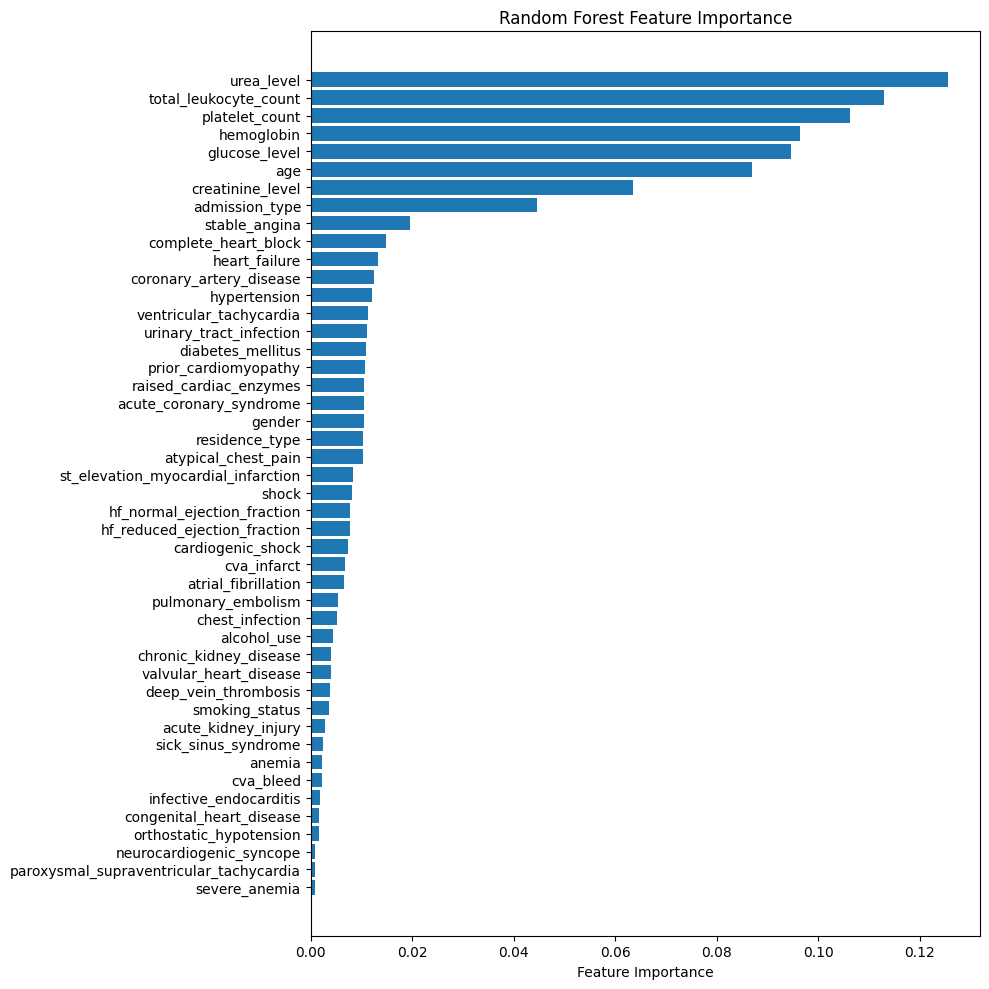

In [26]:
# Plot
plt.figure(figsize=(10,10))
plt.barh(feature_importance["feature"], feature_importance["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [27]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_valid_scaled)

regression_summary(model, y_valid, y_pred)


--- model evaluation ---
model: LinearRegression
MAE: 2.565
RMSE: 3.331
R²: 0.202


In [28]:
from sklearn.linear_model import Lasso

# Lasso regression with explicit regularization and convergence control
model = Lasso(alpha=0.01, max_iter=10000, random_state=42)
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_valid_scaled)

regression_summary(model, y_valid, y_pred)


--- model evaluation ---
model: Lasso
MAE: 2.581
RMSE: 3.336
R²: 0.199


In [29]:
from sklearn.linear_model import Ridge

# Ridge regression with explicit regularization
model = Ridge(alpha=1.0)
model.fit(x_train_scaled, y_train)

y_pred = model.predict(x_valid_scaled)

regression_summary(model, y_valid, y_pred)


--- model evaluation ---
model: Ridge
MAE: 2.565
RMSE: 3.33
R²: 0.202


In [30]:
# Train Random Forest on selected features (with reproducibility)

rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

rf.fit(x_train, y_train)
y_pred = rf.predict(x_valid)

regression_summary(rf, y_valid, y_pred)



--- model evaluation ---
model: RandomForestRegressor
MAE: 2.462
RMSE: 3.244
R²: 0.243


In [31]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting with reproducibility
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(x_train, y_train)

y_pred_gbr = gbr.predict(x_valid)

regression_summary(gbr, y_valid, y_pred_gbr)


--- model evaluation ---
model: GradientBoostingRegressor
MAE: 2.596
RMSE: 3.354
R²: 0.191


In [32]:
from xgboost import XGBRegressor

# XGBoost regression with reproducibility and safe defaults
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(x_train, y_train)

y_pred_xgb = xgb.predict(x_valid)

regression_summary(xgb, y_valid, y_pred_xgb)



--- model evaluation ---
model: XGBRegressor
MAE: 2.575
RMSE: 3.33
R²: 0.202


In [33]:
results_df

,model,mae,rmse,r2
0,Baseline_Median,2.868505,3.913563,-0.102106
1,RandomForestRegressor,2.417614,3.200506,0.262918
2,LinearRegression,2.565166,3.330622,0.201767
3,Lasso,2.580764,3.336290,0.199049
4,Ridge,2.565142,3.330414,0.201868
5,RandomForestRegressor,2.461616,3.243895,0.242797
6,GradientBoostingRegressor,2.595974,3.353570,0.190730
7,XGBRegressor,2.575147,3.330461,0.201845


### Hyper perameter tuning

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Parameter grid
param_dist = {
    "n_estimators": randint(200, 800),
    "max_depth": randint(5, 30),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None]
}

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

# Randomized CV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring="r2",
    random_state=42,
    n_jobs=-1
)

rf_random.fit(x_train, y_train)

# Best model
best_rf = rf_random.best_estimator_

# Predict & evaluate
y_pred = best_rf.predict(x_valid)
regression_summary(best_rf, y_valid, y_pred)

# Best parameters
print("Best params:", rf_random.best_params_)
best_params = rf_random.best_params_



--- model evaluation ---
model: RandomForestRegressor
MAE: 2.522
RMSE: 3.255
R²: 0.238
Best params: {'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 720}


In [35]:
best_params = {'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 720}

# Combine validation and test feature matrices


In [36]:
x_train_final = pd.concat([x_train, x_valid], axis=0)
y_train_final = pd.concat([y_train, y_valid], axis=0)

print("Final train shape:", x_train_final.shape, y_train_final.shape[0])

Final train shape: (12429, 22) 12429


In [37]:
from sklearn.ensemble import RandomForestRegressor

final_model = RandomForestRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)

final_model.fit(x_train_final, y_train_final)

# -------------------------------
# 3. FINAL evaluation on TEST
# -------------------------------
y_pred = final_model.predict(x_test)

regression_summary(
    model=final_model,
    y_valid=y_test,
    y_pred=y_pred
)


--- model evaluation ---
model: RandomForestRegressor
MAE: 2.555
RMSE: 3.283
R²: 0.217


In [38]:
results_df

,model,mae,rmse,r2
0,Baseline_Median,2.868505,3.913563,-0.102106
1,RandomForestRegressor,2.417614,3.200506,0.262918
2,LinearRegression,2.565166,3.330622,0.201767
3,Lasso,2.580764,3.336290,0.199049
4,Ridge,2.565142,3.330414,0.201868
5,RandomForestRegressor,2.461616,3.243895,0.242797
6,GradientBoostingRegressor,2.595974,3.353570,0.190730
7,XGBRegressor,2.575147,3.330461,0.201845
8,RandomForestRegressor,2.521973,3.254680,0.237754
9,RandomForestRegressor,2.554827,3.283434,0.217113


In [ ]:
import pickle

# File path
model_path = r"HealthAI\models\length_of_stay\length_of_stay_prediction_model.pkl"

# Save model
with open(model_path, "wb") as file:
    pickle.dump(final_model, file)